In [1]:
import os
import azure.cognitiveservices.speech as speechsdk

# This example requires environment variables named "SPEECH_KEY" and "SPEECH_REGION"
speech_config = speechsdk.SpeechConfig(subscription="a5455f062a5c422ab8fa8e062713601c", region="westus")
audio_config = speechsdk.audio.AudioOutputConfig(use_default_speaker=True)

# The neural multilingual voice can speak different languages based on the input text.
speech_config.speech_synthesis_voice_name='en-US-AvaMultilingualNeural'

speech_synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config, audio_config=audio_config)


def speak(text = "hello"):
    speech_synthesis_result = speech_synthesizer.speak_text_async(text).get()

    if speech_synthesis_result.reason == speechsdk.ResultReason.SynthesizingAudioCompleted:
        print("Speech synthesized for text [{}]".format(text))
    elif speech_synthesis_result.reason == speechsdk.ResultReason.Canceled:
        cancellation_details = speech_synthesis_result.cancellation_details
        print("Speech synthesis canceled: {}".format(cancellation_details.reason))
        if cancellation_details.reason == speechsdk.CancellationReason.Error:
            if cancellation_details.error_details:
                print("Error details: {}".format(cancellation_details.error_details))
                print("Did you set the speech resource key and region values?")


: 

In [2]:

# import os
# from openai import AzureOpenAI
# from azure.identity import DefaultAzureCredential, get_bearer_token_provider

# endpoint = "https://westusdeployment.openai.azure.com/"
# deployment = "gpt4o"
      
      
# client = AzureOpenAI(
#     azure_endpoint=endpoint,
#     api_key="cf79102ef923421cad64474d96c1a7ff", 
#     api_version="2024-02-01",
# )
      


In [2]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) 

# Replace this with the primary/secondary key, AMLToken, or Microsoft Entra ID token for the endpoint
api_key = 'IXr1FwgBwSyyk2AFaareSZLS8COv9Jyb'
if not api_key:
    raise Exception("A key should be provided to invoke the endpoint")

headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key), 'azureml-model-deployment': 'finetune-llava-v1-5-13b2-1' }



In [3]:
def test_slm(prompt, image_url):

    data = {"image_file" : image_url,
            "image_prompt" : prompt}



    url = "https://gpu-workspace-lyslf.northeurope.inference.ml.azure.com/score"

    body = str.encode(json.dumps(data))
    req = urllib.request.Request(url, body, headers)

    try:
        response = urllib.request.urlopen(req)

        result = response.read().decode("utf8")
        print(result)
        return result
    except urllib.error.HTTPError as error:
        print("The request failed with status code: " + str(error.code))

        # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
        print(error.info())
        print(error.read().decode("utf8", 'ignore'))
test_slm("What is this person doing?", "https://raw.githubusercontent.com/ambianic/fall-detection/main/fall_dataset/fall/74.jpg")

[{"0": "<s> falling, tripping, falling down stairs</s>"}]


'[{"0": "<s> falling, tripping, falling down stairs</s>"}]'

In [5]:
def test_llm(prompt, image_url):
    completion = client.chat.completions.create(
        model=deployment,
        messages=[
            {"role": "user", 
            "content": [
                {"type": "text", "text": prompt}, 
                {"type": "image_url", "image_url": {
                    "url": image_url, 
                    "detail": 
                    "low"}}]} 
            ]
    )

    json_out = json.loads(completion.to_json())

    msg = json_out["choices"][-1]["message"]["content"]
    print(msg)

#test_llm("What is this person doing?", "https://raw.githubusercontent.com/ambianic/fall-detection/main/fall_dataset/fall/74.jpg")

In [6]:
# import os
# import json
# import time



# fall_data_dir = "C:/Users/antonslutsky/Dev/Data/fall-detection/fall_dataset/fall"
# not_fall_data_dir = "C:/Users/antonslutsky/Dev/Data/fall-detection/fall_dataset/not-fall"

# fall_files = os.listdir(fall_data_dir)

# prompt= "What is this person doing?"

# #with open("fall_out.csv", "w") as out:
# if True:
#     for i in range(20):
#         try:
#             img = fall_files[i]
            
#             img = f"https://raw.githubusercontent.com/ambianic/fall-detection/main/fall_dataset/fall/{img}"

#             print(img)

#             start = time.time()
#             test_slm(prompt, img)
#             end = time.time()
#             slm_time = end - start

#             start = time.time()
#             test_llm(prompt, img)
#             end = time.time()
#             llm_time = end - start

#             #out.write(f"{img},{slm_time},{llm_time}\n")
#         except:
#             print(f"Skipping {img}")





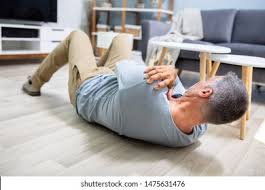

In [4]:
import base64

def encode_image(image_data):
    encoded_string = base64.b64encode(image_data).decode("utf8")
    image_file = 'data:image/jpeg;base64,' + encoded_string
    return image_file

with open("C:/Users/antonslutsky/Dev/Data/fall-detection/fall_dataset/fall/22.jpg", "rb") as image_file:
    image_file = encode_image(image_file.read())

    print(image_file)

Image data: /9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExMVFhUWGBUVFRcVGBcXFhUVFRUWFxUVFRUYHSggGBolHRcVITEhJSkrLi4uFx8zODMtNygtLi0BCgoKDg0OFxAQGi0dHSYtLS0vLS0rLS0tKystKy0tLS0tLS0tLS0tLSstLS0tLS0tLS0tLS0tLS0tLS0tLSstN//AABEIAL4BCQMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAFAgMEBgcBAAj/xABMEAACAAMFBQQGBwQHBQkAAAABAgADEQQFEiExBhNBUXEiYYGRBzJSobHRFCNCcsHh8BVTYpIWJENzgpOyFzM0wtJEVGSDoqOzw/H/xAAZAQADAQEBAAAAAAAAAAAAAAAAAQIDBAX/xAAkEQACAgMAAgEFAQEAAAAAAAAAAQIRAxIhMVEiBBNBYXGBMv/aAAwDAQACEQMRAD8AxYR6kcrCVOcUA/LhysIQxx3rDsVDoaFViJi5Q+j1ENMTR1dTH0tsMP6hZv7pP9Ij5n1Jzj6a2IH9Qs390n+kQIGHxHawkR5jABWtoZxVsjFfkWh5hwira98G9pfVZuUUiw3w6PMMtsJCnSMM3g1wroesNkmFsLI48DEi+tnVZcYLgjMClc4rV1bWWyYD9eMuaqYVN22tqTFQujAgn1BFNNkqkybd6thzVvIwTRTh0PlA2RtvaDrg/lidN2ttG5Djd1rTNcvjBlfEn7QsS63+hE80BNNIg2a6N44fHSvDKEzdurWM93Ib/CR+Meu/0iO3rWeUD0i38miYrVMlSVAy1FYPyrTRD6uYplrQaQLk7ZqdbPK8oOyb3VkDbhOkPIvi2/Qsf/SS9nLPZAEL8SPKA91y/r69YsU685QXtyiBxKH8Ig2FrK7lpDksMipGkT+IRNPDnL+htDlC1jySxodaRMBEauZiokSserEliKRQrTtDOV2WoyYjTkYqLsTi

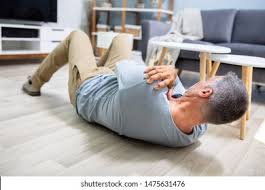

In [5]:
import io
from PIL import Image

img_base64_pref = 'data:image/jpeg;base64,'

if image_file.startswith(img_base64_pref):
    img_data = image_file[len(img_base64_pref):]
    print("Image data:", img_data)
    msg = base64.b64decode(img_data)
    buf = io.BytesIO(msg)
    image = Image.open(buf).convert('RGB')

image


In [6]:
import cv2
import time
from io import BytesIO

cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

def cv2_to_pil(img): #Since you want to be able to use Pillow (PIL)
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    

    pil_image = cv2_to_pil(frame)

    im_file = BytesIO()
    pil_image.save(im_file, format="JPEG")
    im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
    im_b64 = base64.b64encode(im_bytes).decode("utf8")

    image_file = 'data:image/jpeg;base64,' + im_b64

    res = test_slm("What do you see?", image_file)

    if "thumbs up" in res:
        speak("Thumbs up!")
        #break
    if "smiling" in res:
        speak("Looks like you are happy.")

    cv2.imshow("test", frame)

    #break

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.jpg".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

[{"0": "<s> man, beard, glasses</s>"}]
[{"0": "<s> man, beard, glasses</s>"}]
[{"0": "<s> man, beard, glasses</s>"}]
[{"0": "<s> man, glasses</s>"}]
[{"0": "<s> man, couch, sitting</s>"}]
[{"0": "<s> man, glasses</s>"}]
[{"0": "<s> man, glasses, beard</s>"}]
[{"0": "<s> man, glasses</s>"}]
[{"0": "<s> man, glasses</s>"}]
[{"0": "<s> man, glasses, beard</s>"}]
[{"0": "<s> man, glasses, beard</s>"}]
[{"0": "<s> man, glasses, beard</s>"}]
[{"0": "<s> man, glasses, beard</s>"}]
[{"0": "<s> man, couch, sitting</s>"}]
[{"0": "<s> man, thumbs up</s>"}]
Speech synthesized for text [Thumbs up!]
[{"0": "<s> man, beard, glasses</s>"}]
[{"0": "<s> man, glasses</s>"}]
[{"0": "<s> man, glasses, beard</s>"}]
[{"0": "<s> man, glasses, beard</s>"}]
[{"0": "<s> man, glasses, beard</s>"}]
[{"0": "<s> man, couch, sitting</s>"}]
[{"0": "<s> man, glasses</s>"}]
[{"0": "<s> man, couch, sitting</s>"}]
[{"0": "<s> man, glasses, beard</s>"}]
[{"0": "<s> man, couch, sitting</s>"}]
[{"0": "<s> man, glasses, beard